In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Preprocessing and run hSBM

In [3]:
# import some libraries
import pandas as pd
import numpy as np
import os, sys

In [ ]:
#install scanpy
!pip install scanpy
import scanpy as sc

     |████████████████████████████████| 7.2MB 3.1MB/s 
     |████████████████████████████████| 122kB 52.6MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 


In [ ]:
#install graph-tool
!echo "deb http://downloads.skewed.de/apt/ bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo
sys.path.append('/content/drive/My Drive/phd/hsbm-occam/')

Executing: /tmp/apt-key-gpghome.mV8vrJaxsp/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://developer.download.nvidia.com/compu

In [4]:
os.chdir('/content/drive/My Drive/phd/datasets/gtex/10')

# Download data or get the data

## Use already downloaded (example from TCGA) data

In [ ]:
df = pd.read_csv("mainTable_tpm_all_seed314.csv", index_col=0)
df.index = [g[:15] for g in df.index]
df.drop_duplicates(subset=df.index.name, ignore_index=False, inplace=True)
df_files=pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t', index_col=0)
df_files = df_files[df_files.index.isin(df.columns)]
print(df.shape)

(15148, 1000)


## Import from GTEx

This needs to download a big dataset, may require time

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz', skiprows=2, sep='\t', index_col=0)
df.index=[g[:15] for g in df.index]
df=df[df.index.isin(pd.read_csv("http://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None).values.ravel())]
df_files=pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t', index_col=0)
df_files = df_files[df_files.index.isin(df.columns)]
df_files.head()

,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,SMNABTCHT,SMNABTCHD,SMGEBTCH,SMGEBTCHD,SMGEBTCHT,SMAFRZE,SMGTC,SME2MPRT,SMCHMPRS,SMNTRART,SMNUMGPS,SMMAPRT,SMEXNCRT,SM550NRM,SMGNSDTC,SMUNMPRT,SM350NRM,SMRDLGTH,SMMNCPB,SME1MMRT,SMSFLGTH,SMESTLBS,SMMPPD,SMNTERRT,SMRRNANM,SMRDTTL,SMVQCFL,SMMNCV,SMTRSCPT,SMMPPDPR,SMCGLGTH,SMGAPPCT,SMUNPDRD,SMNTRNRT,SMMPUNRT,SMEXPEFF,SMMPPDUN,SME2MMRT,SME2ANTI,SMALTALG,SME2SNSE,SMMFLGTH,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,0.0,B1,"2 pieces, ~15% vessel stroma, rep delineated",6.8,Adipose Tissue,Adipose - Subcutaneous,0002190,1214.0,1125.0,BP-43693,RNA Extraction from Paxgene-derived Lysate Pla...,09/17/2013,LCSET-4804,03/05/2014,TruSeq.v1,RNASEQ,NaN,0.986026,345562.0,0.966793,NaN,0.990383,0.756726,NaN,23548.0,1.0,NaN,76.0,NaN,0.002403,136.0,0.0,66833200.0,0.032919,209558.0,67482200.0,8797660.0,NaN,23575.0,33158000.0,NaN,NaN,0.0,0.210067,0.990383,0.749449,66833200.0,0.003919,14462700.0,8914900.0,14575600.0,144.0,14648800.0,11999300.0,0.003158,14669500.0,50.0354,0.003105,0.994740,NaN,0.0,50.1944
GTEX-1117F-0426-SM-5EGHI,0.0,B1,"2 pieces, !5% fibrous connective tissue, delin...",7.1,Muscle,Muscle - Skeletal,0011907,1220.0,1119.0,BP-43495,RNA Extraction from Paxgene-derived Lysate Pla...,09/12/2013,LCSET-4764,02/09/2014,TruSeq.v1,RNASEQ,NaN,0.985786,145441.0,0.978816,NaN,0.990413,0.838961,NaN,20246.0,1.0,NaN,76.0,NaN,0.002413,137.0,0.0,59963600.0,0.020952,423484.0,60544100.0,9601460.0,NaN,20259.0,29785800.0,NaN,NaN,0.0,0.139855,0.990413,0.830918,59963600.0,0.005538,13154500.0,8383440.0,13125800.0,139.0,13191500.0,11550200.0,0.003968,13340500.0,50.2809,0.006995,0.995041,NaN,0.0,49.9455
GTEX-1117F-0526-SM-5EGHJ,0.0,B1,"2 pieces, clean, Monckebeg medial sclerosis, r...",8.0,Blood Vessel,Artery - Tibial,0007610,1221.0,1120.0,BP-43495,RNA Extraction from Paxgene-derived Lysate Pla...,09/12/2013,LCSET-4764,02/09/2014,TruSeq.v1,RNASEQ,NaN,0.983859,223040.0,0.971360,NaN,0.988930,0.767837,NaN,22193.0,1.0,NaN,76.0,NaN,0.002631,126.0,0.0,59839400.0,0.028310,173556.0,60509200.0,9407590.0,NaN,22218.0,29681000.0,NaN,NaN,0.0,0.203524,0.988930,0.759337,59839400.0,0.005929,12951200.0,6139790.0,13090100.0,125.0,13175400.0,11000300.0,0.004271,13150900.0,49.9535,0.002868,0.994001,NaN,0.0,50.2667
GTEX-1117F-0626-SM-5N9CS,1.0,B1,"2 pieces, up to 4mm aderent fat/nerve/vessel, ...",6.9,Blood Vessel,Artery - Coronary,0001621,1243.0,1098.0,BP-43956,RNA Extraction from Paxgene-derived Lysate Pla...,09/25/2013,LCSET-4904,03/22/2014,TruSeq.v1,RNASEQ,NaN,0.990294,174501.0,0.970076,NaN,0.991275,0.769820,NaN,23331.0,1.0,NaN,76.0,NaN,0.003053,136.0,0.0,69859200.0,0.029643,376087.0,70474000.0,3633120.0,NaN,23354.0,34766500.0,NaN,NaN,0.0,0.200257,0.991275,0.763103,69859200.0,0.003671,15167600.0,6124860.0,15220100.0,151.0,15164200.0,11617900.0,0.003362,15291900.0,50.2096,0.005337,0.992257,NaN,0.0,50.0865
GTEX-1117F-0726-SM-5GIEN,1.0,B1,"2 pieces, no abnormalities",6.3,Heart,Heart - Atrial Appendage,0006631,1244.0,1097.0,BP-44261,RNA Extraction from Paxgene-derived Lysate Pla...,10/03/2013,LCSET-4796,02/27/2014,TruSeq.v1,RNASEQ,NaN,0.990734,184394.0,0.978830,NaN,0.993223,0.803478,NaN,22000.0,1.0,NaN,76.0,NaN,0.003114,131.0,0.0,62885700.0,0.020891,1936430.0,63314800.0,8252970.0,NaN,22015.0,31291500.0,NaN,NaN,0.0,0.175352,0.993223,0.798033,62885700.0,0.003772,13636600.0,9075650.0,13612800.0,146.0,13627100.0,9266070.0,0.003442,13756700.0,50.2367,0.030584,0.995711,NaN,0.0,49.9563


In [ ]:
df_files.to_csv("files.dat")

In [ ]:
df = df[df.columns[df.columns.isin(df_files.index)]]
df.head(2)

                 GTEX-1117F-0226-SM-5GZZ7  ...  GTEX-ZZPU-2726-SM-5NQ8O
ENSG00000227232                    8.7640  ...                   2.1670
ENSG00000238009                    0.0000  ...                   0.0212
ENSG00000268903                    3.2150  ...                   6.2960
ENSG00000269981                    7.0120  ...                  12.5900
ENSG00000228463                    0.7821  ...                   2.7890

[5 rows x 17382 columns]


### Sample columns
We pick some samples at random. We get $100$ samples from 10 most represented tissues

In [ ]:
rs = np.random.RandomState(seed=314)
samples = pd.DataFrame(columns=df_files.columns)
for site in df_files.groupby('SMTS').count().sort_values('SMTSD',ascending=False).index[:10]:
  samples = samples.append(df_files[df_files['SMTS']==site].sample(100, random_state=rs))

In [ ]:
# chack and verify the sampling process
samples.groupby('SMTS').count().sort_values('SMTSD',ascending=False)

NameError: ignored

In [ ]:
df[samples.index].to_csv("mainTable_tpm_all_seed314.csv")

In [ ]:
df_files.to_csv("files.dat")

# Select Highly Variable Genes

We use scanpy to select hvg

In [ ]:
samples = df_files[df_files.index.isin(df.columns)]
genes = df.index
print(len(samples), len(genes))

1000 15148


In [ ]:
adata = sc.AnnData(X=df.reindex(index=genes, columns=samples.index).transpose(), obs=samples)

In [ ]:
sc.pp.log1p(adata, copy=False)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, n_bins=50)

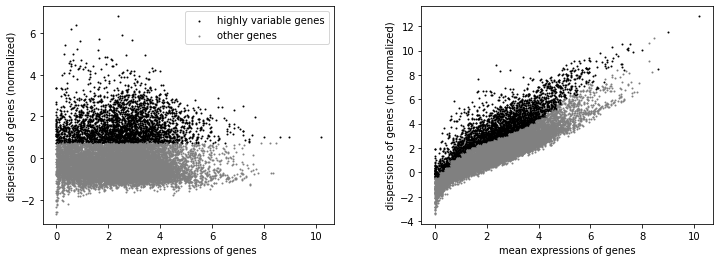

In [ ]:
sc.pl.highly_variable_genes(adata, log=False, save='hvg.pdf')

In [ ]:
hvg = adata.var[adata.var['highly_variable']==True].index
samples = adata.obs.index

Save a new table with only hvg

In [ ]:
file_name = "mainTable_tpm_all_hv.csv"
df.reindex(index=hvg, columns=samples).to_csv(file_name)
from google.colab import files 
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_files.to_csv("files.dat")
files.download("files.dat")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Select HouseKeeping

We download [Human House Keeping genes](https://www.cell.com/trends/genetics/fulltext/S0168-9525(13)00089-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0168952513000899%3Fshowall%3Dtrue) from [https://www.tau.ac.il/~elieis/HKG/](https://www.tau.ac.il/~elieis/HKG/HK_exons.xlsx)

In [5]:
hk = pd.read_excel("HK_exons.xlsx")["Gene Name"].unique()

Here we use [https://www.genenames.org](https://www.genenames.org) to convert  genes' names to Ensamble' ids

In [6]:
hgcn_url = "https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_app_name&col=md_ensembl_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_name&format=text&submit=submit"
df_conversion=pd.read_csv(hgcn_url, sep="\t")

In [ ]:
df_hk_ensg = df_conversion[(df_conversion["Approved symbol"].isin(hk))&(df_conversion["Ensembl ID(supplied by Ensembl)"].isin(df.index))]["Ensembl ID(supplied by Ensembl)"].drop_duplicates().values

In [ ]:
df_hk = df.reindex(index=df_hk_ensg)
df_hk.to_csv("mainTable_hk.csv", index=True)

# Run Stochastic Block Model
We run [stochastic block model](https://github.com/martingerlach/hSBM_Topicmodel/tree/develop)

In [ ]:
from sbmtm import sbmtm

# create the model
model = sbmtm()

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


In [ ]:
samples = samples
genes = hvg
print(len(samples), len(genes))

1000 3000


### make a graph with the data


In [ ]:
df = pd.read_csv("mainTable_counts_hv.csv", index_col=0)
genes = df.index
samples = pd.Series(index=df.columns)
print(len(samples), len(genes))

In [ ]:
# .applymap(lambda tpm: np.log2(tpm+1))
model.make_graph_from_BoW_df(df.reindex(index=genes, columns=samples.index).dropna())
model.save_graph("graph_tpm_seed314.xml.gz")
model.g

<Graph object, undirected, with 4000 vertices and 2032164 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fa2a88a5f98>

### load data
Use this only if you **already have a *graph.xml.gz*** file

In [ ]:
# load graph
model.load_graph("graph_counts.xml.gz")
model.g

### load pretrained
Use this only if you **already have a *topsbm.pkl*** file with a trained model 

In [ ]:
# load pretrainded
import graph_tool as gt
from graph_tool.inference.nested_blockmodel import NestedBlockState
import pickle

with open("topsbm/topsbm.pkl", "rb") as file:
  model = pickle.load(file)

model.mul

## Run

In [ ]:
os.chdir('/content/drive/My Drive/phd/datasets/gtex/10')
config = "seed"
os.system(f"mkdir -p {config} && mkdir -p {config}/topsbm")
os.chdir(f"{config}/topsbm")

model.fit(n_init=1, parallel=True, verbose=True, B_min=5, B_max=500)
model.multiflip_mcmc_sweep(n_steps=100, verbose=True)
model.save_data()

# check models
You can use these functions to inspect saved models.

Do not use unless needed

In [ ]:
os.chdir("/content/drive/My Drive/phd/datasets/gtex/gtexall")

In [ ]:
df = pd.read_csv("mainTable.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, ENSG00000268903 to ENSG00000008735
Columns: 17382 entries, GTEX-1117F-0226-SM-5GZZ7 to GTEX-ZZPU-2726-SM-5NQ8O
dtypes: int64(17382)
memory usage: 57.7+ MB


In [ ]:
(df>1e5).sum().sum()/df.shape[0]/df.shape[1]*100

0.23299433144381457

In [ ]:
df = pd.read_csv("mainTable_all.csv", index_col=0)

In [ ]:
#os.chdir("/content/drive/My Drive/phd/TOPSBM_TEST")
os.chdir("/content/drive/My Drive/phd/datasets/gtex/10")
os.getcwd()

In [ ]:
import graph_tool as gt
import seaborn as sns
from sbmtm import sbmtm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import matplotlib.pyplot as plt
model = sbmtm()

def load_and_print(graph="graph.xml.gz", **kwargs):
  model.load_graph(graph)
  print(model.g)
  print(len(model.words),len(model.documents))
  data = gt.spectral.adjacency(model.g, weight=model.g.edge_properties["count"]).toarray()
  n_doc = len(model.documents)
  data = data[n_doc:,:n_doc]
  ax = sns.heatmap(data, **kwargs)
  ax.set_ylabel("words", fontsize=35, rotation=90)
  ax.yaxis.tick_left()
  ax.yaxis.set_label_position("left")

  ax.set_xlabel("documents",fontsize=35)
  ax.tick_params(labelsize=25)
  return model, data

def load_trained_and_print(graph="topsbm.pkl", **kwargs):
  import pickle
  with open(graph,"rb") as io:
    model = pickle.load(io)
  print(model.g)
  print(len(model.words),len(model.documents))
  data = gt.spectral.adjacency(model.g, weight=model.g.edge_properties["count"]).toarray()
  n_doc = len(model.documents)
  data = data[n_doc:,:n_doc]
  ax = sns.heatmap(data, **kwargs)
  ax.set_ylabel("words", fontsize=35, rotation=90)
  ax.yaxis.tick_left()
  ax.yaxis.set_label_position("left")

  ax.set_xlabel("documents",fontsize=35)
  ax.tick_params(labelsize=25)
  return model, data

<Graph object, undirected, with 17817 vertices and 4214080 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f1c127f6b00>
435 17382


19.0

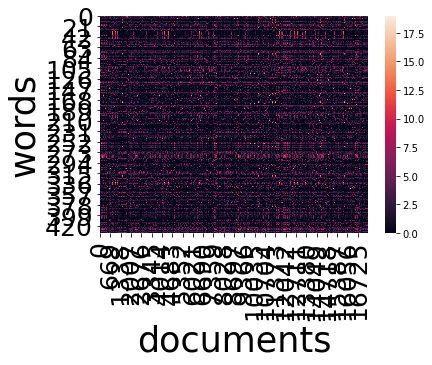

In [ ]:
model, data = load_and_print("topsbm/graph.xml.gz");
data.max()

In [ ]:
load_and_print("graph_hk.xml.gz", vmax=5e3);

In [ ]:
load_and_print("graph_log10.xml.gz");

In [ ]:
ld = os.listdir()
ld.sort()
ld

['.ipynb_checkpoints',
 'HK_exons.xlsx',
 'all',
 'clustersizes.txt',
 'corr_f_pt_topsbm.pdf',
 'cpm',
 'figures',
 'files.dat',
 'graph.xml.gz',
 'graph_counts.xml.gz',
 'graph_counts_null.xml.gz',
 'graph_cpm.xml.gz',
 'graph_cut.xml.gz',
 'graph_hk.xml.gz',
 'graph_log.xml.gz',
 'graph_log10.xml.gz',
 'graph_random1000.xml.gz',
 'graph_rg.xml.gz',
 'graph_tpm.xml.gz',
 'graph_tpm_all.xml.gz',
 'graph_tpm_hk.xml.gz',
 'graph_tpm_hv.xml.gz',
 'graph_tpm_log.xml.gz',
 'graph_tpm_null.xml.gz',
 'graph_tpm_seed314.xml.gz',
 'hierarchical',
 'hierarchical-tpm',
 'hierarchical_dendogram.pdf',
 'hierarchical_dendogram_log.pdf',
 'hk',
 'lda',
 'lda-tpm',
 'log',
 'log10',
 'logcpm',
 'mainTable.csv',
 'mainTable_all.csv',
 'mainTable_counts.csv',
 'mainTable_counts_hv.csv',
 'mainTable_counts_hv_null (1).csv',
 'mainTable_counts_hv_null.csv',
 'mainTable_counts_hv_null_julia.csv',
 'mainTable_cpm.csv',
 'mainTable_cpm_hv.csv',
 'mainTable_hk.csv',
 'mainTable_hv.csv',
 'mainTable_log.csv',


<Graph object, undirected, with 3999 vertices and 483377 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f24ad167b00>
2999 1000


19.0

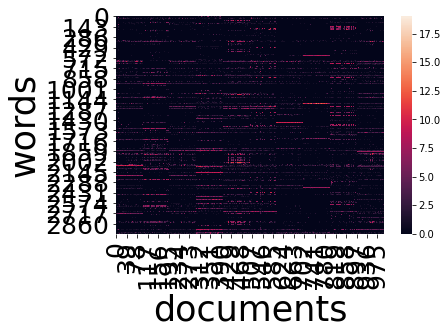

In [ ]:
model, data = load_and_print("graph_log.xml.gz");
data.max()

In [ ]:
df.reindex(index=hvg, columns=samples).loc[[g[:15] for g in model.words[:5]],model.documents[:5]]

In [ ]:
model.save_graph("graph_tpm_hv.xml.gz")

In [ ]:
model.load_graph("topsbm/graph_hde.xml.gz")

In [ ]:
model.multiflip_mcmc_sweep(n_steps=10)

In [ ]:
df = df.drop_duplicates()
df.reindex(index=pd.read_csv("topsbm-rg/topsbm-rg_level_0_word-dist.csv", index_col=0).index).to_csv("mainTable-rg.csv")

In [ ]:
df.index=[g[:15] for g in df.index]